In [70]:
%pylab
%matplotlib inline
from numba import jit, njit

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


The best units for this type of problem are the total mass, the orbital separation, and the dynamical time. In these units G=1.

First we set up the derivative function for the restricted 3-body problem, and our RK4 integrator. Note that I'm being fancy here and decorating these functions with @njit and @jit respectively, which compiles them with Numba for a >10x speedup.

In [71]:
#Rjup = 5.345
q = 9.5458e-4 # jupiter-sun mass ratio
#mega = 0.5083
#Gmsun = 39.42
#Gmjup = q * Gmsun

@njit
def ThreeBodyDeriv(y, t):
    q = 9.5458e-4
    m1 = 1/(1+q)
    m2 = q/(1+q)
    
    pos = y[:2]
    v = y[2:]
        
    # coordinates of the gravitating bodies in the corotating frame
    x2 = m1/(m1+m2)
    y2 = 0
    x1 = -m2/(m1+m2)
    y1 = 0
    
    # we'll store GMi/Ri^3 for efficient reuse
    fac1 = np.sqrt((pos[0]-x1)*(pos[0]-x1) +  (pos[1]-y1)*(pos[1]-y1))
    fac1 = m1/(fac1*fac1*fac1)
    
    fac2 = np.sqrt((pos[0]-x2)*(pos[0]-x2) +  (pos[1]-y2)*(pos[1]-y2))
    fac2 = m2/(fac2*fac2*fac2)
    
    # gravitational acceleration
    ax = (x1 - pos[0]) * fac1 + (x2 - pos[0]) * fac2
    ay = (y1 - pos[1]) * fac1 + (y2 - pos[1]) * fac2
    
    # Coriolis 
    ax += -2 * (-v[1])
    ay += -2 * v[0]
    
    # Centrifugal
    ax += pos[0]
    ay += pos[1]
    
    return np.array([y[2],y[3], ax, ay])

@jit
def RK4(deriv, y0, h, T, args=()):
    Nsteps = int(T/h + 0.5)
    y = np.empty((Nsteps+1, len(y0)))
    y[0] = y0
    t = np.linspace(0, Nsteps*h, Nsteps + 1)
    for i in range(Nsteps):
        k1 = h * deriv(y[i], t[i], *args) # euler step
        k2 = h * deriv(y[i] + 0.5*k1, t[i] + 0.5*h, *args) # midpoint step
        k3 = h * deriv(y[i] + 0.5*k2, t[i] + 0.5*h, *args) # refined midpoint step
        k4 = h * deriv(y[i] + k3, t[i] + h, *args) # whole step using the refined midpoint step
        y[i+1] = y[i] + k1/6 + k2/3 + k3/3 + k4/6
    return t, y

# Motion about the L4 Lagrange point

Now I'll do some integrations for 100 orbits for various values of the angle alpha, to show that orbits at alpha=pi/3 stay put, but alphas off of that oscillate about the L4 point stably.

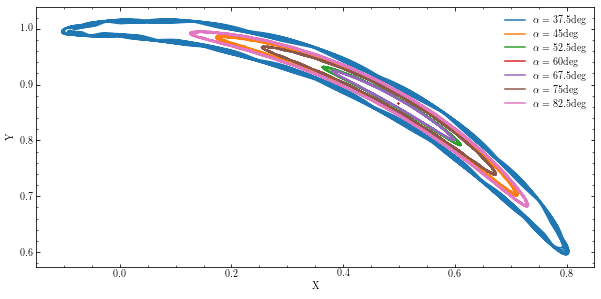

In [72]:
m1 = 1/(1+q)
m2 = q/(1+q)
R = (m1-m2)

alphas = np.pi/3 + np.pi/24 * np.arange(-3,4) # 15deg increments

plt.figure(figsize=(10,10))

for alpha in alphas:

    y0 = np.array([R*np.cos(alpha),np.sin(alpha) + np.random.normal()*1e-5, 0.,0.])

    Tmax = 2*np.pi*100
    t, y = RK4(ThreeBodyDeriv, y0, 0.01, Tmax)

    plt.plot(y[:,0], y[:,1], label=r"$\alpha=%g{\rm deg}$"%(alpha*180/np.pi))
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.axes().set_aspect('equal')
plt.savefig("L4_Lagrange_Stable.pdf", bbox_inches='tight')

On the other hand, trying say alpha=pi/12 gets too close to Jupiter, so the orbit gets kicked all over the place.

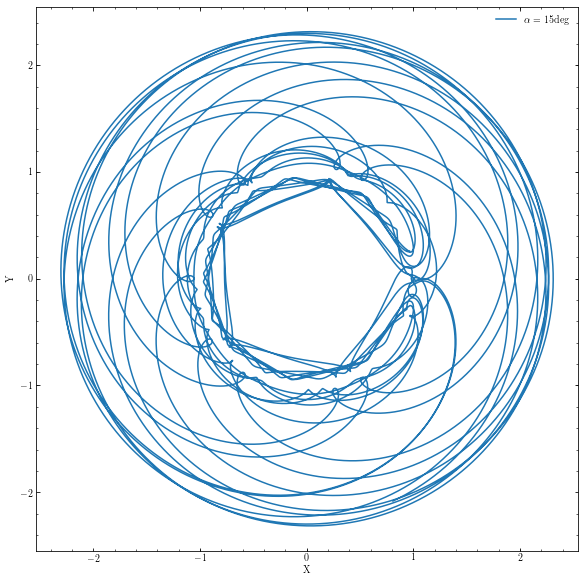

In [73]:
alphas = np.pi/12, # 15deg increments

plt.figure(figsize=(10,10))

for alpha in alphas:

    y0 = np.array([R*np.cos(alpha),np.sin(alpha) + np.random.normal()*1e-5, 0.,0.])

    Tmax = 2*np.pi*110
    t, y = RK4(ThreeBodyDeriv, y0, 0.001, Tmax)

    plt.plot(y[:,0], y[:,1], label=r"$\alpha=%g{\rm deg}$"%(alpha*180/np.pi))
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.axes().set_aspect('equal')
plt.savefig("L4_Chaotic.pdf", bbox_inches='tight')

# Unrestricted 3-body problem

Now let's get us a general-purpose N-body derivative function. We will pack the dynamical variables as (x1, y1, z1, x2, y2, z2.... vx1, vy1, vz1, vx2...). At the heart of the function is the gravitational force summation, which is the most computationally demanding part for large N.

In [84]:
@njit
def GravAccel(x,m,h=0,G=1.):
    """
    Returns the gravitational acceleration of N mutually-interacting masses.
    
    Parameters:
    x - (N, 3) array containing positions of masses
    m - (N,) array containing masses
    h - Gravitational softening parameter for Plummer-like softening
    G - Gravitational constant
    
    Returns:
    accel - (N,3) array of gravitational accelerations
    
    """        
    accel = np.zeros_like(x)
    
    for i in range(x.shape[0]):
        for j in range(i+1,x.shape[0]):
            dx = x[j,0]-x[i,0]
            dy = x[j,1]-x[i,1]
            dz = x[j,2]-x[i,2]
            
            r = np.sqrt(dx*dx + dy*dy + dz*dz + h*h)
            
            mr3inv = m[i]/(r*r*r)
            accel[j,0] -= mr3inv*dx
            accel[j,1] -= mr3inv*dy
            accel[j,2] -= mr3inv*dz

            mr3inv = m[j]/(r*r*r)
            accel[i,0] += mr3inv*dx
            accel[i,1] += mr3inv*dy
            accel[i,2] += mr3inv*dz
    return G*accel

@njit
def NbodyDeriv(y, t, masses, h=0., G=1.):
    # unpack the positions as a (N,3) array
    deriv_out = np.empty_like(y)
    
    N = len(y)//6
    
    pos = y[:(3*N)].reshape((N,3))
    acc = GravAccel(pos, masses, h, G).reshape((3*N,)) # then re-pack the accelerations as needed
    
    deriv_out[:(3*N)] = y[(3*N):]
    deriv_out[(3*N):] = acc
    return deriv_out
    

Now let's set up and integrate the Lagrange choreography

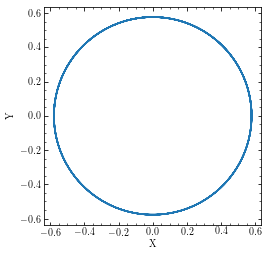

In [107]:
angles = 0, 2*np.pi/3, 4*np.pi/3 # angles of the 3 vertices of the triangle

pos = [[np.cos(a)/np.sqrt(3), np.sin(a)/np.sqrt(3), 0] for a in angles]  # positions
v = [[-np.sin(a), np.cos(a), 0] for a in angles]

masses = np.ones(3)

y0 = np.concatenate([np.concatenate(pos), np.concatenate(v)])

Tmax = 20.
dt = 0.01

t, y = RK4(NbodyDeriv, y0, dt, Tmax, (masses,))

plt.plot(y[:,0], y[:,1])
plt.xlabel("X")
plt.ylabel("Y")
plt.axes().set_aspect('equal')
plt.savefig("Lagrange_3body.pdf", bbox_inches='tight')